# Women's Suffrage in South Australia

## 1. Scraping Metadata from Trove

In [1]:
import requests  # for using API
import xml.etree.ElementTree as ET  # for parsing XML
import numpy as np  # for using pandas
import pandas as pd  # for using dataframes
import json
from bs4 import BeautifulSoup
from pathlib import Path  
from datetime import datetime
import math

In [2]:
url = 'https://trove.nla.gov.au/api/search/137'
headers = {
    'accept': 'application/json, text/plain, */*',
    'apikey': 'ea389fab9020e8ce3b4bf0aa756acd0a', # this api key is changed daily and need to be obtained from the network panel in Chrome dev tools. It cannot be replaced with user's api key.
    'referer': 'https://trove.nla.gov.au/'
}
params = {
    'terms': '("voting rights" OR "suffrage")',
    'limits': '{"state":["South Australia"],"advArtType":["newspapers"],"date.from":["1894-12-17"],"date.to":["1894-12-19"]}',
    'startPos': 0,
    'pageSize': 200
}

response = requests.get(url, headers=headers, params=params)
data = response.json()

In [3]:
# Serializing json
json_object = json.dumps(data, indent=4)
 
# Writing to sample.json
with open("data_women-suffrage-17to19.json", "w") as outfile:
    outfile.write(json_object)

In [4]:
metadata = pd.DataFrame(data['works'])
filepath = Path('data_women-suffrage-17to19.csv')
metadata.to_csv(filepath)

## Scraping Articles with Metadata from Trove 

In [5]:
filtered_metadata = pd.read_csv('data_women-suffrage-17to19.csv')[['id','title', 'formatDisplay', 'newspaper', 'date', 'articleType', 'wordCount']]
print(len(filtered_metadata.index), 'metadata entries loaded')

48 metadata entries loaded


In [6]:
def extract_text(id):
    html_doc = requests.get('https://trove.nla.gov.au/newspaper/article/' + str(id))
    soup = BeautifulSoup(html_doc.text, 'html.parser')
    form_element = soup.select_one('#fulltextContents > form')
    scroll_text = form_element.find('div', class_=['alert', 'sr-only'])
    if scroll_text is not None:
        form_element.find('div', class_=['alert', 'sr-only']).decompose()
    # Extract the inner text of the 'form' element
    inner_text = form_element.get_text(separator=' ', strip=True)
    return inner_text

In [7]:
filtered_metadata['text'] = filtered_metadata['id'].apply(extract_text)
filtered_metadata['date'] = filtered_metadata['date'].apply(lambda x: datetime.strptime(x, '%A %d %B %Y').strftime('%d-%m-%Y'))

In [8]:
filepath = Path('full-text-data_women-suffrage17to19.csv')
filtered_metadata.to_csv(filepath)

## Data Cleaning and Pre-processing

In [9]:
import re
import spacy

In [10]:
article_data = pd.read_csv('full-text-data_women-suffrage17to19.csv')

In [11]:
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS 

def clean_text(text):
    text = re.sub(r'(\w+-) ([a-z]\w+)', r'\1\2', text) # Dehyphenate words split across 2 lines
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    text = nlp(text)
    text = [token for token in text if not token.is_stop] 
    text = ' '.join([token.lemma_ for token in text])
    return text

article_data['cleanedText'] = article_data['text'].apply(clean_text)

## Summary Statistics about the Data

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

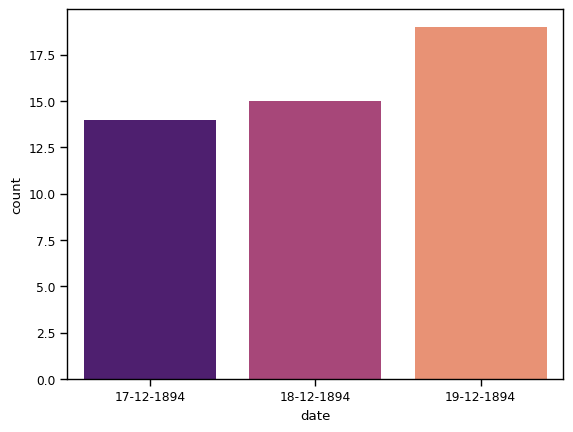

In [13]:
sns.set_context('paper')
sns.countplot(x = 'date', data = article_data.sort_values(by=['date']), palette = 'magma')
plt.show()

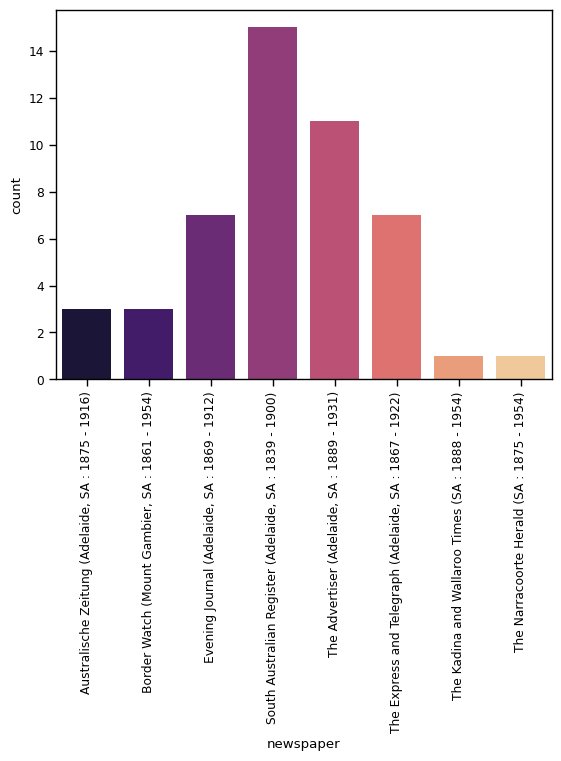

In [15]:
sns.countplot(x = 'newspaper', data = article_data.sort_values(by=['newspaper']), palette = 'magma')
plt.xticks(rotation=90)
plt.show()

## Word Cloud

In [16]:
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
from fuzzywuzzy import fuzz
from tqdm import tqdm
from spellchecker import SpellChecker

In [17]:
df17, df18, df19 = [x.reset_index() for _, x in article_data.groupby(['date'])]

In [18]:
wordcloud = WordCloud(min_word_length=4,
                      collocations=True, 
                      relative_scaling=0.5)

def count_word_frequency(text):
    text_dictionary = wordcloud.process_text(text)
    word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
    return word_freq

In [19]:
wc_text17 = ' '.join(df17['cleanedText'])
wc_text18 = ' '.join(df18['cleanedText'])
wc_text19 = ' '.join(df19['cleanedText'])
wc_text_all = ' '.join(article_data['cleanedText'])
wc_text_list = [wc_text17, wc_text18, wc_text19, wc_text_all]

In [20]:
wc_dict_list = []
for wc_text in wc_text_list:
    result = count_word_frequency(wc_text)
    wc_dict_list.append(result)

In [21]:
filename_counter = 17
def produce_wordcloud_plot(text):
    wordcloud = WordCloud(min_word_length=4,
                         collocations=True,
                         collocation_threshold = 10,
                         background_color = "black",
                         repeat = True,
                          max_words =50,
                          scale=5,
                          colormap="spring_r"
                         )
    wordcloud.generate(text)
    filename = str(filename_counter)+'-wordcloud.png'
    #plot
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(filename, dpi='figure')
    plt.show
    

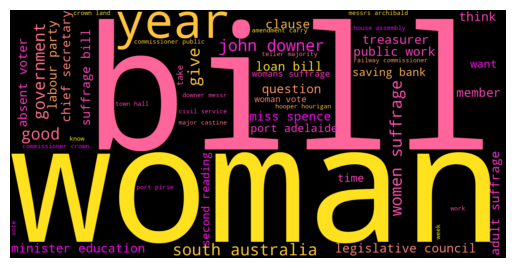

In [22]:
for wc_text in wc_text_list:
    produce_wordcloud_plot(wc_text)
    filename_counter = filename_counter + 1

## Topic Modelling

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [24]:
def tfidf(cleaned_texts):
    stopwords_extension = ['would']
    # the vectorizer object will be used to transform text to vector form
    vectorizer = CountVectorizer(stop_words = stopwords_extension, token_pattern='[a-zA-Z0-9]{4,}', ngram_range=(1,2))
    
    # apply transformation
    tf = vectorizer.fit_transform(cleaned_texts).toarray()
    # tf_feature_names tells us what word each column in the matric represents
    tf_feature_names = vectorizer.get_feature_names_out()
    return tf, tf_feature_names

def produce_topic_models(tf, number_of_topics):
    model = LDA(n_components=number_of_topics, random_state=0)
    model.fit(tf)
    return model

In [25]:
topic_model_input_list = [df17['cleanedText'], df18['cleanedText'], df19['cleanedText']]
topic_models = []
for input in topic_model_input_list:
    tf, tf_feature_names = tfidf(input)
    topic_models.append((tf, tf_feature_names, produce_topic_models(tf, 5)))

tf, tf_feature_names = tfidf(article_data['cleanedText'])
topic_models.append((tf, tf_feature_names, produce_topic_models(tf, 8)))

In [26]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 15

for tf, tf_feature_names, model in topic_models:
    print(display_topics(model, tf_feature_names, no_top_words))

           Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights  \
0             councillor             5.2      adelaide            48.2   
1                buttery             3.2          good            47.2   
2                   vote             3.2          port            44.2   
3                   poll             3.2          want            35.2   
4              candidate             3.2          year            33.2   
5                 number             3.2      december            29.2   
6                   ward             3.2      saturday            26.2   
7                norwood             3.2         apply            25.2   
8                 return             3.2        office            25.2   
9                   town             3.2          town            21.2   
10              occasion             2.2          lady            21.2   
11              election             2.2       tuesday            21.2   
12  councillor threlfall             2

In [27]:
def save_topics_to_png(df, output_filename):
    # Number of topics
    n_topics = int(df.shape[1] / 2)
    
    # Calculate the number of rows needed for the given number of topics
    n_rows = math.ceil(n_topics / 2)
    
    # Create a figure and set of subplots in a 2-column format
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
    
    # Flatten the 2D array of axes for easier iteration
    axes = axes.ravel()
    
    for idx, ax in enumerate(axes[:n_topics]):
        # Extract relevant columns
        words_col = f"Topic {idx} words"
        weights_col = f"Topic {idx} weights"
        
        # Create a new DataFrame for the topic
        topic_df = df[[words_col, weights_col]].dropna()
        topic_df[weights_col] = topic_df[weights_col].astype(float)  # Convert weights to float
        
        # Plot
        topic_df.set_index(words_col).plot(kind='bar', legend=False, ax=ax)
        ax.set_ylabel("Weight")
        ax.set_title(f"Topic {idx}")
        
        # Increase font size for x-axis labels
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    
    # If the number of topics is odd, remove the last unused subplot
    if n_topics % 2 != 0:
        fig.delaxes(axes[-1])
    
    # Adjust layout
    plt.tight_layout()
    
    # Save to PNG
    plt.savefig(output_filename)
    plt.close()


filename_counter = 17

for tf, tf_feature_names, model in topic_models:
    df = display_topics(model, tf_feature_names, no_top_words)
    save_topics_to_png(df, str(filename_counter)+"-topic.png")
    filename_counter +=1

In [28]:
most_prominent_article_idx = []

for tf, tf_feature_names, model in topic_models:
    topic_distribution = model.transform(tf)
    
    # Identify the article where each topic is most prominent
    most_prominent_article_idx.append(topic_distribution.argmax(axis=0))

In [29]:
df_list = [df17, df18, df19, article_data]
for df, article_idx_list in zip(df_list, most_prominent_article_idx):
    for topic_idx, article_idx in enumerate(article_idx_list):
        print(f"Topic {topic_idx} is most prominent in Article {article_idx} {df['id'][article_idx]}")

Topic 0 is most prominent in Article 9 53650246
Topic 1 is most prominent in Article 11 209045438
Topic 2 is most prominent in Article 13 73201844
Topic 3 is most prominent in Article 10 202828127
Topic 4 is most prominent in Article 12 53650257
Topic 0 is most prominent in Article 8 25744774
Topic 1 is most prominent in Article 4 25744868
Topic 2 is most prominent in Article 7 25744796
Topic 3 is most prominent in Article 14 53658083
Topic 4 is most prominent in Article 13 53658165
Topic 0 is most prominent in Article 6 25744927
Topic 1 is most prominent in Article 16 229182566
Topic 2 is most prominent in Article 18 25744975
Topic 3 is most prominent in Article 3 53660002
Topic 4 is most prominent in Article 13 229182561
Topic 0 is most prominent in Article 20 209045551
Topic 1 is most prominent in Article 14 25744774
Topic 2 is most prominent in Article 29 53650292
Topic 3 is most prominent in Article 43 25744975
Topic 4 is most prominent in Article 36 53658083
Topic 5 is most promi